In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
import numpy as np
import cv2 
import os


def dataset_setup(data_dir='', n_ims=2975, offset_bias=0, img_dim=256):
    """
    Method to import the training data from CityScape and divide into image-label pairs

    Inputs
    --
    data_dir: string
        Location for the data that is being imported
    n_ims: int
        Number of images contained in the folder chosen
    offset_bias: int
        Optionally, skip some images by starting at a position further than 0
    img_dim: int
        Expected image dimension (assuming square images)

    Outputs
    --
    X: list
        Images
    y: list
        Image labels per pixel
    """

    flist = os.listdir(data_dir)
    img0 = cv2.imread(data_dir+flist[0])

    y_dim,x_dim,_ = np.shape(img0)
    X = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    y = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    
    k = 0
    for f in flist[offset_bias:offset_bias+n_ims]:
        X[k] = cv2.imread(data_dir+f)[:,:img_dim]/img_dim
        y[k] = cv2.imread(data_dir+f)[:,img_dim:]/img_dim
        k = k+1

    return X, y

In [2]:
import matplotlib.pyplot as plt

# Directories containing the train and val data
train_files = "./ECE228_project/data/train/"
val_files = "./ECE228_project/data/val/"

# Setup image-label pairs
x_train, y_train = dataset_setup(data_dir=train_files, n_ims=2975, offset_bias=0, img_dim=256)
x_val, y_val = dataset_setup(data_dir=val_files, n_ims=500, offset_bias=0, img_dim=256)

In [12]:
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose, Conv2D, concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras import Model, Input


def conv2d_block(input_tensor, n_filters=16, filter_size=3, activation='relu', pad='same', batch_norm=True):
    """
    Custom block method to perform consecutive convolutions with optional batch normalization

    Inputs
    --
    input_tensor: tensor
        Input image tensor data structure defined within Keras
    n_filters: int
        Depth for the convolution layer outputs
    filter_size: int
        Dimensions of the filter convolved with the tensor inputs
    activation: string
        Activation function for the intermediate layers between convolutions
    pad: string
        Determination of if input shape is maintained in convolution
    batch_norm: bool
        Flag if batch normalization is used

    Outputs
    --
    x: tensor
        Twice convolved input with optional batch normalization and activation non-linearities
    """
    
    x = Conv2D(filters=n_filters, kernel_size=(filter_size, filter_size),
               kernel_initializer='he_normal', padding=pad)(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters=n_filters, kernel_size=(filter_size, filter_size),
               kernel_initializer='he_normal', padding=pad)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


def UNET_plusplus(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=32, dropout=0.5, padding='same', batch_norm=True):
    """
    UNET++ architecture as originally outlined in https://arxiv.org/pdf/1807.10165.pdf with modifications 
    to fit different input dimensions. 

    Inputs
    --
    input_shape: tuple(int)
        Tuple in 3D corresponding to the dimensions of the input images
    conv_block: func
        Custom block method to perform consecutive convolutions with optional batch normalization
    n_filters: int
        Number of filters corresponding to depth of input for next layer
    dropout: float
        Dropout percentage hyperparameter to tune overfitting
    padding: string
        Descriptor determining if padding maintain size during convolutions
    batch_norm: bool
        Determines if batch normalization is used

    Outputs
    --
    model: Model
        Returns model architecture without compile
    """

    tensor = Input(shape=input_shape)

    print('Backbone')
    
    c00 = conv_block(tensor, n_filters * 1, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p00 = MaxPooling2D((2, 2))(c00)
    p00 = Dropout(dropout)(p00)
    
    c10 = conv_block(p00, n_filters * 2, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p10 = MaxPooling2D((2, 2))(c10)
    p10 = Dropout(dropout)(p10)

    c20 = conv_block(p10, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p20 = MaxPooling2D((2, 2))(c20)
    p20 = Dropout(dropout)(p20)

    c30 = conv_block(p20, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p30 = MaxPooling2D((2, 2))(c30)
    p30 = Dropout(dropout)(p30)

    c40 = conv_block(p30, n_filters * 16, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    
    print('First Up Path')
    
    u01 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c10)
    u01 = concatenate([u01, c00])
    u01 = Dropout(dropout)(u01)
    c01 = conv_block(u01, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    c01_out = Conv2D(3, (1, 1), activation='sigmoid')(c01)  
    
    print('Second Up Path')

    u11 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c20)
    u11 = concatenate([u11, c10])
    u11 = Dropout(dropout)(u11)
    c11 = conv_block(u11, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u02 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c11)
    u02 = concatenate([u02, c01, c00])
    u02 = Dropout(dropout)(u02)
    c02 = conv_block(u02, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm) 
    c02_out = Conv2D(3, (1, 1), activation='sigmoid')(c02)  
    
    print('Third Up Path')

    u21 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding=padding)(c30)
    u21 = concatenate([u21, c20])
    u21 = Dropout(dropout)(u21)
    c21 = conv_block(u21, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)   

    u12 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c21)
    u12 = concatenate([u12, c11, c10])
    u12 = Dropout(dropout)(u12)
    c12 = conv_block(u12, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u03 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c12)
    u03 = concatenate([u03, c02, c01, c00])
    u03 = Dropout(dropout)(u03)
    c03 = conv_block(u03, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    c03_out = Conv2D(3, (1, 1), activation='sigmoid')(c03)     

    print('Final Up Path')

    u31 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding=padding)(c40)
    u31 = concatenate([u31, c30])
    u31 = Dropout(dropout)(u31)
    c31 = conv_block(u31, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm) 

    u22 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding=padding)(c31)
    u22 = concatenate([u22, c21, c20])
    u22 = Dropout(dropout)(u22)
    c22 = conv_block(u22, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u13 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c22)
    u13 = concatenate([u13, c12, c11, c10])
    u13 = Dropout(dropout)(u13)
    c13 = conv_block(u13, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u04 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c13)
    u04 = concatenate([u04, c03, c02, c01, c00])
    u04 = Dropout(dropout)(u04)
    c04 = conv_block(u04, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)  

    #Outputs
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c04)
    model = Model(inputs=[tensor], outputs=[outputs])
#     loss_1 = MSE(tensor, c01_out)
#     loss_2 = MSE(tensor, c02_out)
#     loss_3 = MSE(tensor, c03_out)
#     loss_4 = MSE(tensor, outputs)
#     model.add_loss(loss_1+loss_2+loss_3+loss_4)

    # Return model architecture
    return model

In [13]:
# Initialize UNET
model = UNET_plusplus(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=32, dropout=0.5, padding='same', batch_norm=True)
print(model.summary())

Backbone
First Up Path
Second Up Path
Third Up Path
Final Up Path
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 256, 256, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 256, 256, 32) 128         conv2d_102[0][0]                 
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 256, 256, 32) 0           batch_normalization_90[0][0]     
__________________________

In [14]:
# Compile model with specified optimizer and loss
model.compile(optimizer='adam', loss='MSE')

In [15]:
# Track model history as it trains
import tensorflow as tf
print(tf.__version__)

h = model.fit(x_train, y_train, epochs=3, shuffle=True, batch_size=10, validation_data=(x_val, y_val))

2.1.0
Train on 2975 samples, validate on 500 samples
Epoch 1/3
2975/2975 [==============================] - 144s 48ms/sample - loss: 0.0250 - val_loss: 0.0447
Epoch 2/3
2975/2975 [==============================] - 132s 44ms/sample - loss: 0.0174 - val_loss: 0.0212
Epoch 3/3
2975/2975 [==============================] - 132s 44ms/sample - loss: 0.0154 - val_loss: 0.0146


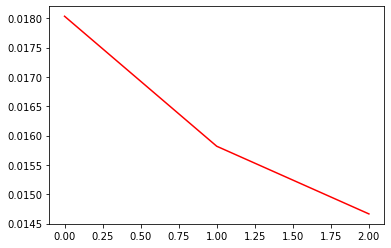

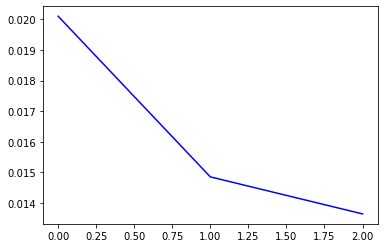

In [14]:
# Print results for training MSE and validation MSE
plt.plot(h.history['loss'], 'r')
plt.show()
plt.plot(h.history['val_loss'], 'b')
plt.show()

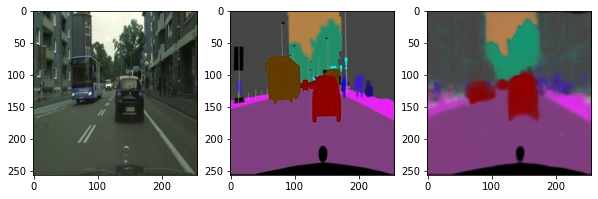

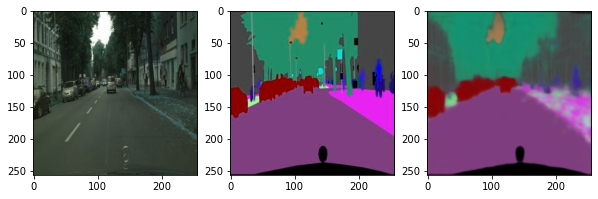

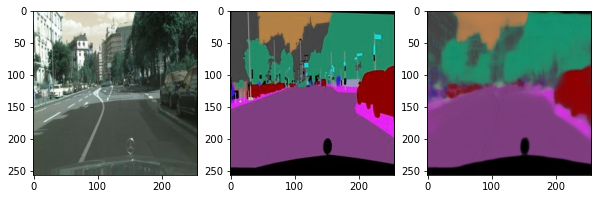

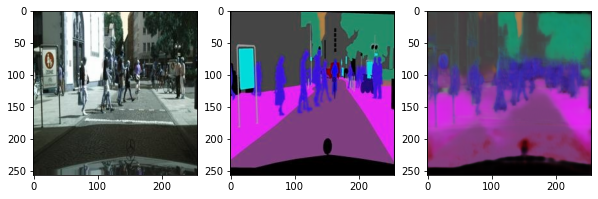

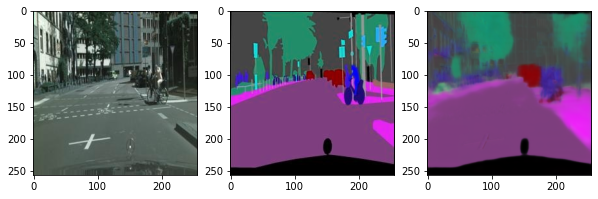

In [15]:
#show the result
pp = model.predict(x_val[0:5,:,:,:])

ni = 5
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pp[k])

In [19]:
intersection = np.logical_and(y_val[0:1,:,:,:], pp[1])
union = np.logical_or(y_val[0:1,:,:,:], pp[1])
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.9520416259765625


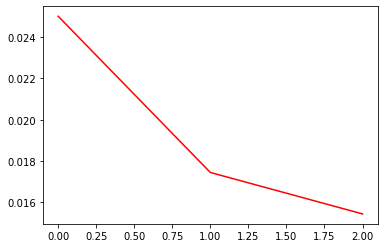

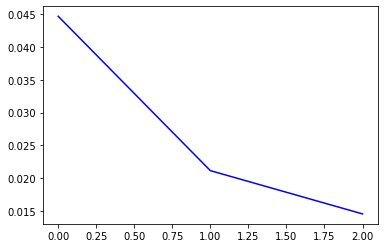

In [16]:
# Print results for training MSE and validation MSE
plt.plot(h.history['loss'], 'r')
plt.show()
plt.plot(h.history['val_loss'], 'b')
plt.show()

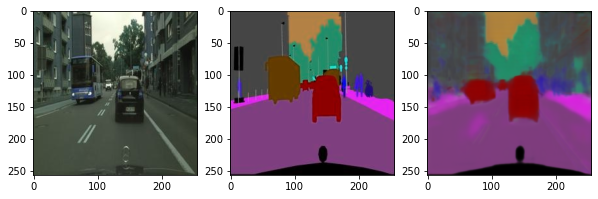

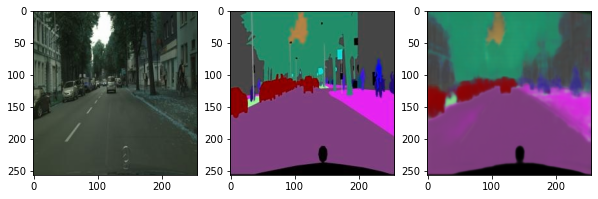

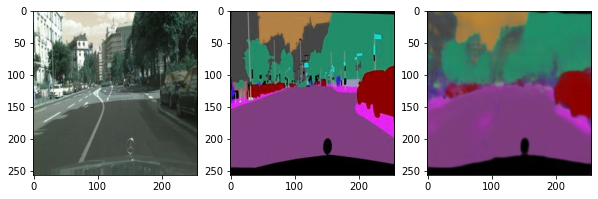

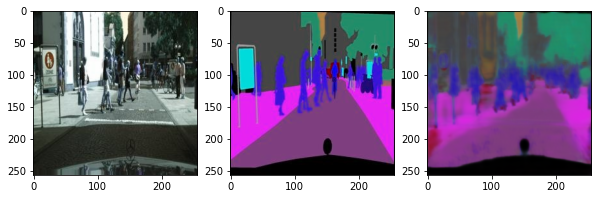

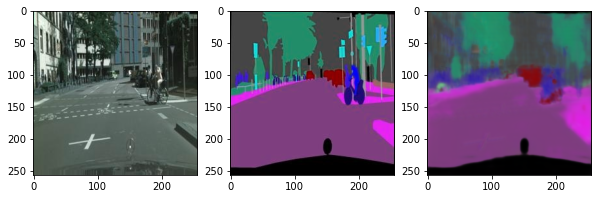

In [17]:
#show the result
pp = model.predict(x_val[0:5,:,:,:])

ni = 5
for k in range(ni):

    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_val[k])
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_val[k])
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pp[k])

In [18]:
intersection = np.logical_and(y_val[0:1,:,:,:], pp[1])
union = np.logical_or(y_val[0:1,:,:,:], pp[1])
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.9520416259765625
